In [ ]:
# 필요한 라이브러리 임포트
import os
import json
import random
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
import zipfile
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터셋 다운로드
if not os.path.exists("seg_dataset"):
    !gdown https://drive.google.com/uc?id=1AbU0ghVIxP81SR8_L17wtzdZwSvZvRZl
    !unzip -qq seg_dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1AbU0ghVIxP81SR8_L17wtzdZwSvZvRZl
From (redirected): https://drive.google.com/uc?id=1AbU0ghVIxP81SR8_L17wtzdZwSvZvRZl&confirm=t&uuid=0eec03ae-46bc-4b65-a8e0-5b062ed429ed
To: /content/seg_dataset.zip
100% 257M/257M [00:06<00:00, 39.2MB/s]


In [ ]:
# SegmentationDataset 정의
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, labels_dir, image_transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(images_dir))
        self.label_files = sorted(os.listdir(labels_dir))

        # 이미지와 레이블 파일의 이름이 일치하는지 확인
        assert len(self.image_files) == len(self.label_files), "이미지와 레이블 파일 수가 일치하지 않습니다."
        for img_file, lbl_file in zip(self.image_files, self.label_files):
            assert os.path.splitext(img_file)[0] == os.path.splitext(lbl_file)[0], f"이미지와 레이블 파일 이름이 일치하지 않습니다: {img_file}, {lbl_file}"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        label_path = os.path.join(self.labels_dir, self.label_files[idx])

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"이미지를 로드하는 중 에러 발생: {image_path}\n{e}")
            raise

        mask = self.create_mask(label_path, image.size)

        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return image, mask

    def create_mask(self, label_path, image_size):
        mask = Image.new('L', image_size, 0)
        with open(label_path, 'r') as f:
            try:
                label_data = json.load(f)
            except json.JSONDecodeError:
                print(f"JSON 파일을 파싱하는 데 실패했습니다: {label_path}")
                return mask  # 빈 마스크 반환

        draw = ImageDraw.Draw(mask)

        # 'segmentation' 키 사용
        shapes = label_data.get('segmentation', None)

        if shapes is None:
            print(f"레이블 데이터에 'segmentation' 키가 없습니다: {label_path}")
            return mask  # 빈 마스크 반환

        for shape in shapes:
            # 좌표 키는 'polygon'입니다
            points = shape.get('polygon', None)
            if points is None:
                print(f"객체에 'polygon' 키가 없습니다: {label_path}")
                continue  # 해당 객체 건너뜀

            # 좌표를 정수로 변환
            points = [tuple(map(int, point)) for point in points]

            # 레이블은 'name' 키에 있습니다
            label = shape.get('name', None)
            if label == 'Parking Space':
                draw.polygon(points, outline=1, fill=1)
            elif label == 'Driveable Space' or label == 'Drivable Space':
                draw.polygon(points, outline=2, fill=2)
            else:
                print(f"알 수 없는 레이블 '{label}'이(가) 있습니다: {label_path}")
                # 필요에 따라 추가 처리 가능
        return mask

In [ ]:
# 이미지 변환 정의
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 마스크 변환 정의
mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long()),
])

In [ ]:
# 데이터 디렉토리 설정
train_images_dir = '/content/seg_dataset/train/images/'
train_labels_dir = '/content/seg_dataset/train/labels/'

val_images_dir = '/content/seg_dataset/validation/images/'
val_labels_dir = '/content/seg_dataset/validation/labels/'

test_images_dir = '/content/seg_dataset/test/images/'
test_labels_dir = '/content/seg_dataset/test/labels/'

# 데이터셋 생성
train_dataset = SegmentationDataset(train_images_dir, train_labels_dir, image_transform=image_transform, mask_transform=mask_transform)
val_dataset = SegmentationDataset(val_images_dir, val_labels_dir, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = SegmentationDataset(test_images_dir, test_labels_dir, image_transform=image_transform, mask_transform=mask_transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

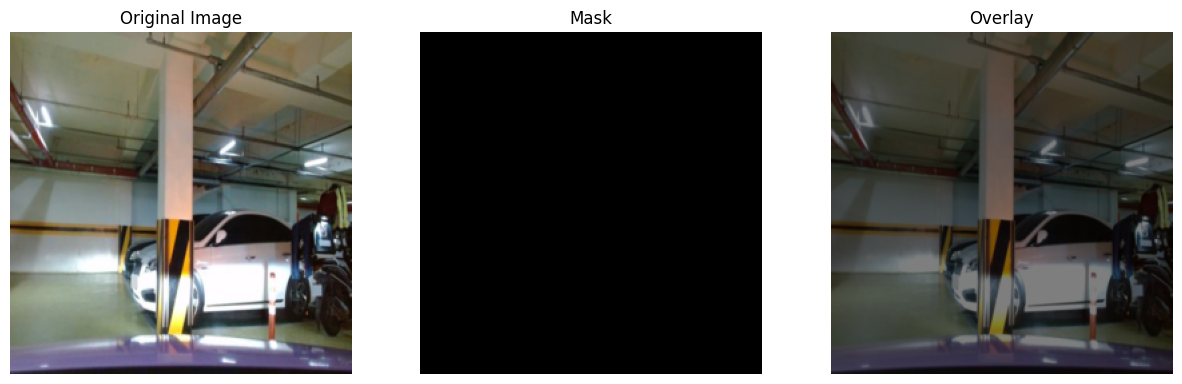

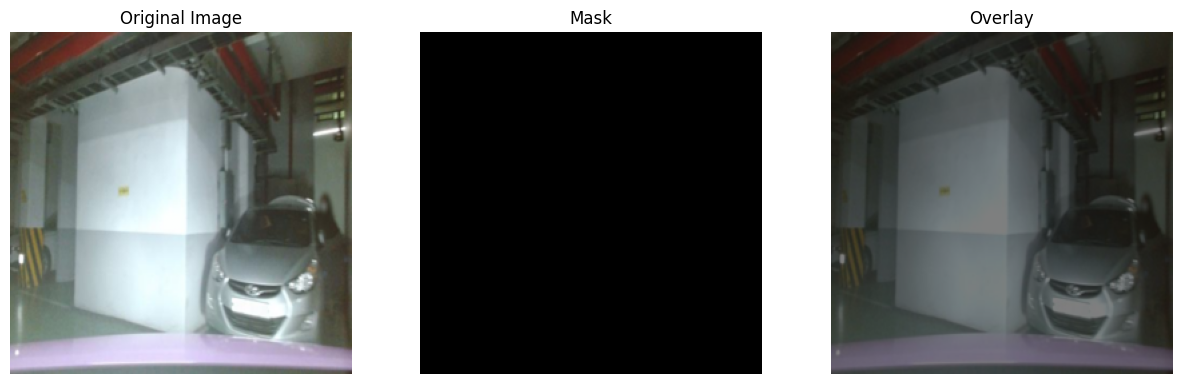

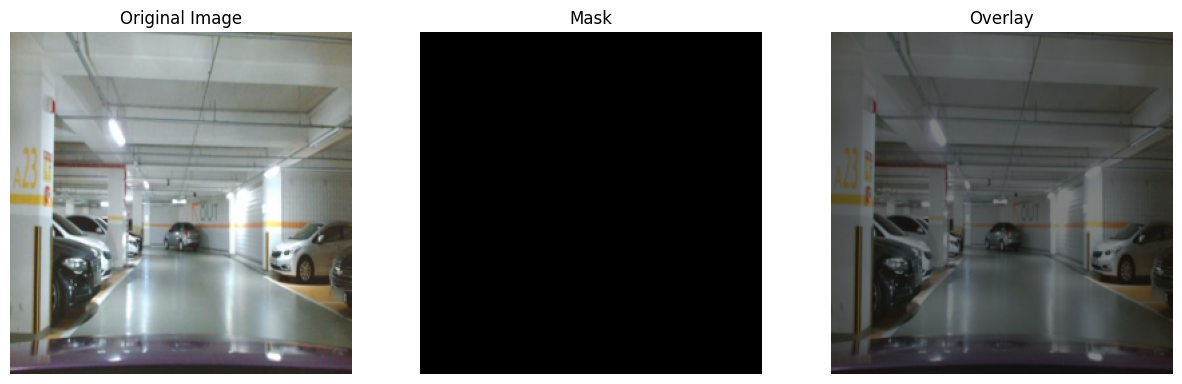

In [ ]:
# 데이터셋 시각화
def visualize_dataset_sample(dataset, num_samples=3):
    indices = random.sample(range(len(dataset)), num_samples)
    for idx in indices:
        image, mask = dataset[idx]
        image_np = image.permute(1, 2, 0).numpy()
        mask_np = mask.numpy()

        # 마스크를 색깔로 변환
        mask_color = np.zeros((mask_np.shape[0], mask_np.shape[1], 3))
        mask_color[mask_np == 1] = [1, 0, 0]  # 클래스 1: 빨강
        mask_color[mask_np == 2] = [0, 1, 0]  # 클래스 2: 초록

        # 마스크 오버레이 생성
        overlay = 0.5 * image_np + 0.5 * mask_color
        overlay = np.clip(overlay, 0, 1)

        # 시각화
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title('Overlay')
        plt.axis('off')

        plt.show()

# 훈련 데이터셋에서 샘플 시각화
visualize_dataset_sample(train_dataset, num_samples=3)


In [ ]:
# 사전 학습된 DeepLabv3+ 모델 로드
model = deeplabv3_resnet50(pretrained=True)

# 클래스 수 설정 (배경 + 클래스 수)
num_classes = 3  # 배경(0) + 주차 공간(1) + 주행 가능 공간(2)

# 분류기 헤드 수정
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1))

# 모델을 GPU로 이동 (가능한 경우)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 136MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
# 손실 함수 및 옵티마이저 정의
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
num_epochs = 50

best_val_loss = float('inf')  # 가장 낮은 검증 손실 저장
save_path = '/content/drive/MyDrive/Team-SW/best50.pth'  # 저장할 파일 이름

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}] 시작")
    # 훈련 단계
    model.train()
    train_loss = 0
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        # 모델 예측
        outputs = model(images)['out']

        # 손실 계산
        loss = criterion(outputs, masks)

        # 역전파 및 옵티마이저 스텝
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"훈련 에폭 {epoch+1}, 배치 {batch_idx+1}/{len(train_loader)}, 손실: {loss.item():.4f}")

    avg_train_loss = train_loss / len(train_loader)

    # 검증 단계
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] 완료, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# 최적 모델 저장
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"새로운 최적의 검증 손실: {best_val_loss:.4f}, 모델 저장됨: {save_path}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
훈련 에폭 10, 배치 450/1216, 손실: 0.0367
훈련 에폭 10, 배치 460/1216, 손실: 0.0134
훈련 에폭 10, 배치 470/1216, 손실: 0.0179
훈련 에폭 10, 배치 480/1216, 손실: 0.0254
훈련 에폭 10, 배치 490/1216, 손실: 0.0170
훈련 에폭 10, 배치 500/1216, 손실: 0.0124
훈련 에폭 10, 배치 510/1216, 손실: 0.0314
훈련 에폭 10, 배치 520/1216, 손실: 0.0170
훈련 에폭 10, 배치 530/1216, 손실: 0.0122
훈련 에폭 10, 배치 540/1216, 손실: 0.0186
훈련 에폭 10, 배치 550/1216, 손실: 0.0224
훈련 에폭 10, 배치 560/1216, 손실: 0.0159
훈련 에폭 10, 배치 570/1216, 손실: 0.0214
훈련 에폭 10, 배치 580/1216, 손실: 0.0133
훈련 에폭 10, 배치 590/1216, 손실: 0.0147
훈련 에폭 10, 배치 600/1216, 손실: 0.0287
훈련 에폭 10, 배치 610/1216, 손실: 0.0788
훈련 에폭 10, 배치 620/1216, 손실: 0.0301
훈련 에폭 10, 배치 630/1216, 손실: 0.0181
훈련 에폭 10, 배치 640/1216, 손실: 0.0400
훈련 에폭 10, 배치 650/1216, 손실: 0.0190
훈련 에폭 10, 배치 660/1216, 손실: 0.0331
훈련 에폭 10, 배치 670/1216, 손실: 0.0281
훈련 에폭 10, 배치 680/1216, 손실: 0.0264
훈련 에폭 10, 배치 690/1216, 손실: 0.0312
훈련 에폭 10, 배치 700/1216, 손실: 0.0124
훈련 에폭 10, 배치 710/1216, 손실: 0.0290
훈련 에폭 10, 배치 720/1216, 손실: 0.0272
훈련 에폭 10, 배치

Test Loss: 0.0437


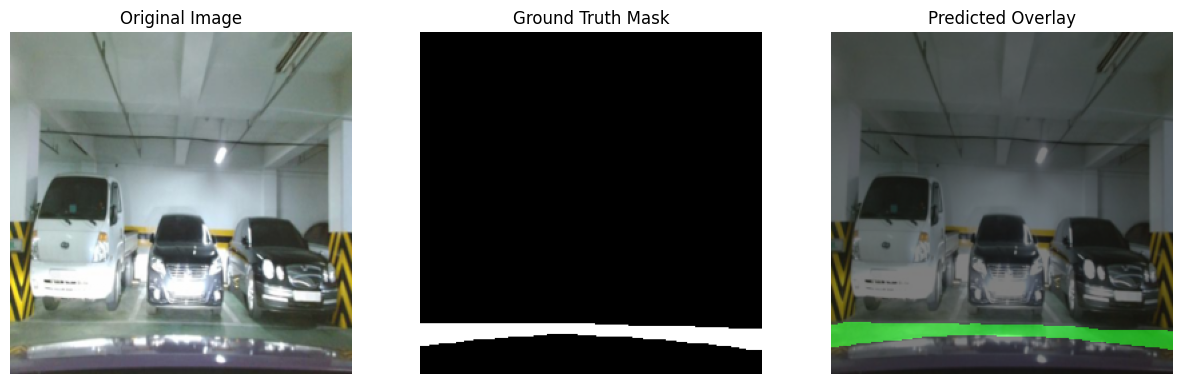

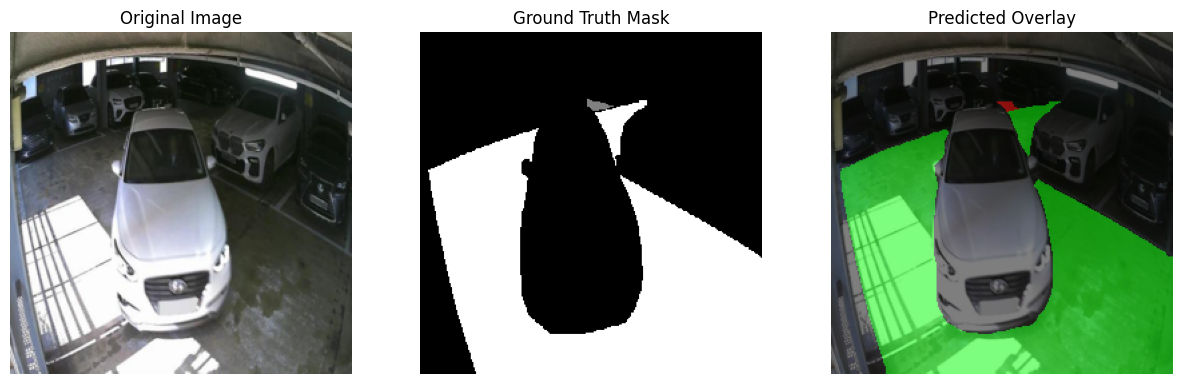

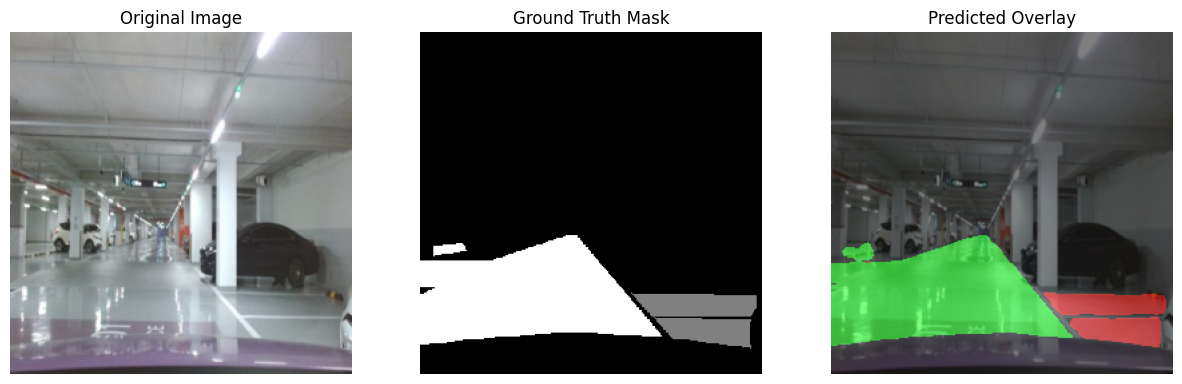

In [ ]:
# 테스트 데이터셋에서 평가
model.eval()
test_loss = 0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

# 샘플 시각화 함수
def visualize_samples(model, dataset, num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    for idx in indices:
        image, mask = dataset[idx]
        image = image.to(device)
        mask = mask.to(device)
        with torch.no_grad():
            output = model(image.unsqueeze(0))['out']
        output_predictions = output.argmax(1).cpu().squeeze(0).numpy()

        image_np = image.cpu().permute(1, 2, 0).numpy()
        mask_np = mask.cpu().numpy()

        # 예측 마스크를 색상으로 변환
        pred_mask_color = np.zeros((output_predictions.shape[0], output_predictions.shape[1], 3))
        pred_mask_color[output_predictions == 1] = [1, 0, 0]  # 클래스 1: 빨강
        pred_mask_color[output_predictions == 2] = [0, 1, 0]  # 클래스 2: 초록

        # 마스크 오버레이 생성
        overlay = 0.5 * image_np + 0.5 * pred_mask_color
        overlay = np.clip(overlay, 0, 1)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title('Predicted Overlay')
        plt.axis('off')

        plt.show()

# 테스트 데이터셋에서 샘플 시각화
visualize_samples(model, test_dataset, num_samples=3)

In [ ]:
# 샘플 시각화 함수
def visualize_samples(model, dataset, num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    for idx in indices:
        image, mask = dataset[idx]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))['out']
        output_predictions = output.argmax(1).cpu().squeeze(0)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(transforms.ToPILImage()(image))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(output_predictions, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

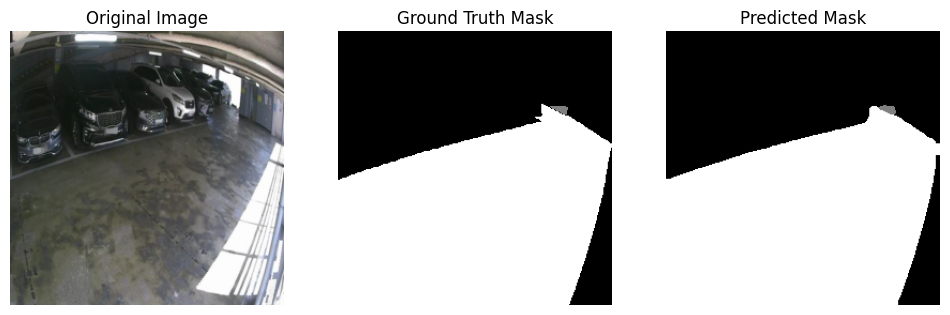

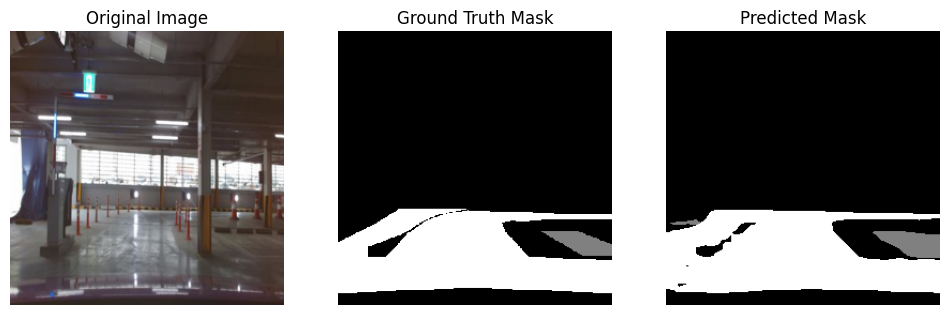

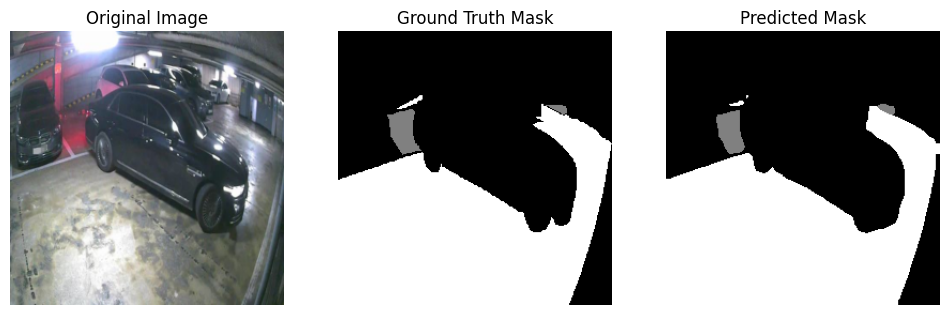

In [ ]:
# 테스트 데이터셋에서 샘플 시각화
visualize_samples(model, test_dataset, num_samples=3)

In [ ]:
# Testing loop
model.eval()
total_iou = 0
total_samples = 0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Model prediction
        outputs = model(images)['out']
        predicted_classes = torch.argmax(outputs, dim=1)

        # Compute IoU for each class
        for class_id in range(num_classes):
            intersection = ((predicted_classes == class_id) & (masks == class_id)).sum().item()
            union = ((predicted_classes == class_id) | (masks == class_id)).sum().item()
            if union > 0:
                total_iou += intersection / union
                total_samples += 1

# Calculate mIoU
miou = total_iou / total_samples
print(f"Test mIoU: {miou:.4f}")


Test mIoU: 0.8717


# 동영상

In [ ]:
import cv2
import numpy as np
import torch
from torchvision import models, transforms

# 모델 경로
model_path = '/content/drive/MyDrive/Team-SW/best50.pth'

# 동영상 파일 경로
video_path = '/content/drive/MyDrive/Team-SW/parkingspace_video(640360).mp4'

# 결과 저장 경로
output_video_path = '/content/drive/MyDrive/Team-SW/parkingspace_video_output.mp4'

# 색상 맵핑 설정
segmentation_colors = {
    0: (0, 0, 0),       # Background
    1: (0, 255, 0),     # Driveable Space
    2: (255, 0, 0)      # Parking Space
}

# GPU/CPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DeepLabV3 모델 초기화 및 가중치 불러오기
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))  # 클래스 수 맞추기

# 모델 가중치 로드 (이미 학습된 모델이 있다면 로드)
model.load_state_dict(torch.load(model_path, map_location=device),strict=False)  # 가중치 로드
model.eval()  # 평가 모드 설정
model.to(device)  # 모델을 GPU/CPU로 이동

# 동영상 로드
cap = cv2.VideoCapture(video_path)

# 동영상 정보 가져오기
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# 출력 동영상 코덱 설정 (MP4V 코덱 사용)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# 입력 이미지 전처리 (DeepLabV3+ 모델에 맞게 RGB로 변환)
preprocess = transforms.Compose([
    transforms.ToPILImage(),  # NumPy 배열을 PIL 이미지로 변환
    transforms.Resize((640, 360)),  # 모델 입력 크기에 맞게 리사이즈
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 표준화
])

# 프레임 단위로 동영상 처리
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 프레임 전처리 (모델 입력 크기에 맞게 리사이즈 및 RGB 변환)
    input_frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR이므로 RGB로 변환
    input_tensor = preprocess(input_frame_rgb).unsqueeze(0).to(device)  # 배치 차원 추가 및 디바이스로 이동

    # 모델 예측
    with torch.no_grad():
        outputs = model(input_tensor)['out']  # DeepLabV3+ 모델의 출력
        outputs = torch.softmax(outputs, dim=1)  # 각 클래스의 확률 계산
        predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy().squeeze()  # 가장 높은 확률을 가진 클래스 선택

    # 세그멘테이션 결과를 컬러 이미지로 변환
    output_colored = np.zeros((*predicted_classes.shape, 3), dtype=np.uint8)
    for class_id, color in segmentation_colors.items():
        output_colored[predicted_classes == class_id] = color

    # 결과 이미지 원본 크기로 리사이즈
    output_colored = cv2.resize(output_colored, (width, height))

    # 결과 이미지와 원본 이미지 합성
    overlay = cv2.addWeighted(frame, 0.6, output_colored, 0.4, 0)

    # 결과 동영상 저장
    out.write(overlay)

# 모든 작업 완료 후 자원 해제
cap.release()
out.release()
print(f"처리가 완료되었습니다. 결과 동영상은 {output_video_path}에 저장되었습니다.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-20-6c5c7d623d0b>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#u

처리가 완료되었습니다. 결과 동영상은 /content/drive/MyDrive/Team-SW/parkingspace_video_output.mp4에 저장되었습니다.
